# 5.4 探究式问题

## 5.4.1 提出问题

（1）以线性分类器为弱分类器，强分类器是如何组合多个线性分类边界形成非线性分类边界？（例如：序列组合不同数量的弱分类器，并可视化强分类器和当前弱分类器在特征空间中的分类边界和数据的权重或分布）

（2）以决策树为弱分类器，强分类器是如何进行样本和特征选择的？（利用AdaBoost的样本分布和DF的特征重要性评价功能）

（3）以高光谱数据多个（所有）波段为输入特征，分析和比较选择不同弱分类器时AdaBoost的分类精度？探讨其原因。

（4）以高光谱数据多个（所有）波段为输入特征，以决策树（1颗树）为分类器，逐类别分析各个特征在分类中的重要性，并与我们常用的遥感指数（NDVI、NDWI、NDBI等）所使用的波段之间的区别与联系。

（5）比较不同节点纯度下决策树特征选择的差异。

（6）RF中树的数量对分类器性能有什么影响？

（7）不同树分类结果集成方法对分类器的分类结果影响是否不大？（加权平均、多数投票）


## 5.4.2 数据集说明

### （1）高光谱影像

数据：HYDICE image

时间：August 23, 1995

地点： Washington, DC mall area 

波段：191波段

来源：https://engineering.purdue.edu/~biehl/MultiSpec/hyperspectral.html 


In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt

import numpy as np
from skimage import io
import scipy.io as sio
from sklearn import preprocessing

#原始数据转为BIP格式后，读取影像数据，并reshape为（nsamples，nfeatures）
hiperSpectral = io.imread('dcBIP.tif');
hang = hiperSpectral.shape[0];  
lie = hiperSpectral.shape[1];  NumberBands = hiperSpectral.shape[2]; 
AllXdata = hiperSpectral.reshape(hang*lie,NumberBands);
scaler = preprocessing.StandardScaler().fit(AllXdata);   # 数据标准化
AllxStandard = scaler.transform( AllXdata );
                  
Ylabel = sio.loadmat('allSampe.mat')['S'];   #样本矩阵的读取
YLabelOnedime = Ylabel.reshape(hang*lie);    #样本Label转为一维向量
print('Rows: ',hang);   print('Cols: ',lie);  print('波段数: ',NumberBands);  

Populating the interactive namespace from numpy and matplotlib
Rows:  1280
Cols:  307
波段数:  191


![](Picture/Sample.JPG)

In [2]:
from sklearn.model_selection import train_test_split
# 训练集和测试集的划分，考虑所以的特征(即191个波段全用)
index=np.where(YLabelOnedime > 0)[0];
Ylabelsample = YLabelOnedime[index];
Xdatasamples = AllxStandard[index,:];
X_train,X_test,y_train,y_test = train_test_split (Xdatasamples,Ylabelsample,test_size = 0.4,random_state=2,stratify = Ylabelsample);
print('训练集的样本数：',len(y_train),'        ','测试集的样本数：',len(y_test) ); 

训练集的样本数： 4847          测试集的样本数： 3232


 ### （2）模拟数据【two blobs】

In [3]:
from matplotlib.colors import ListedColormap
from sklearn import datasets
# Normalized
def Normalized(x):
    minx=np.min(x)
    maxX=np.max(x)
    x=(x-minx)/(maxX-minx)
    return x;
# transform label of class to -1 and 1
def classtransform(x):
    for i in range(0,len(x)):
        if(x[i]>0):
            x[i]=1
        else:
            x[i]=-1
    return x;
# the datasets of two blobs
def makeblods(n):
    np.random.seed(0)
    X,y = datasets.make_blobs(n_samples=n, centers=2, n_features=2, cluster_std = 1.6, random_state = 1)
    rand_X=255*Normalized(X)
    Y=classtransform(y)
    return rand_X,Y;
# 离散化网格
def makeGrids():
    x = np.linspace(0,255,256)
    y = np.linspace(0,255,256)
    X,Y = np.meshgrid(x,y)
    Xzip=list(zip(X.flat,Y.flat))
    # Xzip = np.array(Xzip)
    points = [point for point in zip(X.flat,Y.flat)]
    points = np.array(points)
    return Xzip,points;
#离散网格点生成
Xzip,points = makeGrids()
np.random.shuffle(points)
points = np.array(points)
# 训练样本点3000个，正类和负类各1500个
n_samples = 3000   
XR,yr = makeblods(n_samples)
cor = ListedColormap(['Blue', 'Orange'])

## 5.4.3 问题探讨

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier,Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

### （1）线性弱分类器组合成强分类器【LinearSVC——>AdaBoost】

训练精度:   0.9996666666666667


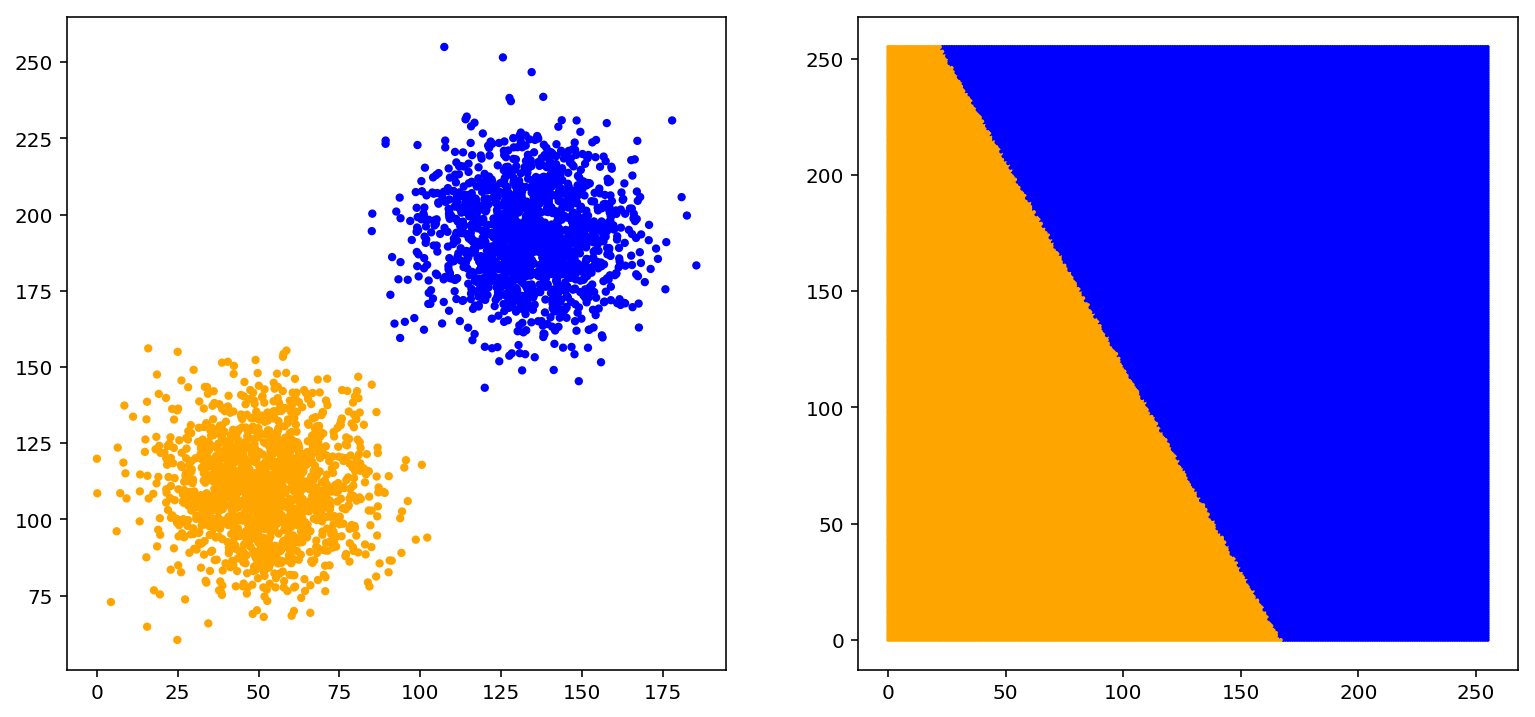

In [5]:
PerceptronAdaBoost = AdaBoostClassifier( base_estimator = svm.LinearSVC(C = 1.0e2), n_estimators = 8, algorithm='SAMME');
PercepAdaBoostFit = PerceptronAdaBoost.fit(XR,yr); 

PercepAdaBoostResult = PercepAdaBoostFit.predict(points);   
TrainScore = PercepAdaBoostFit.score(XR,yr);    print('训练精度:  ', TrainScore);
ABestimator = PercepAdaBoostFit.estimators_
ABweight = PercepAdaBoostFit.estimator_weights_

plt.figure(figsize=(13,6))
plt.subplot(1,2,1);
plt.scatter(XR[:,0],XR[:,1],c = yr,s= 10,cmap=cor)
plt.subplot(1,2,2);
plt.scatter(points[:,0],points[:,1],c = PercepAdaBoostResult,s=0.9,cmap=cor)
plt.show();

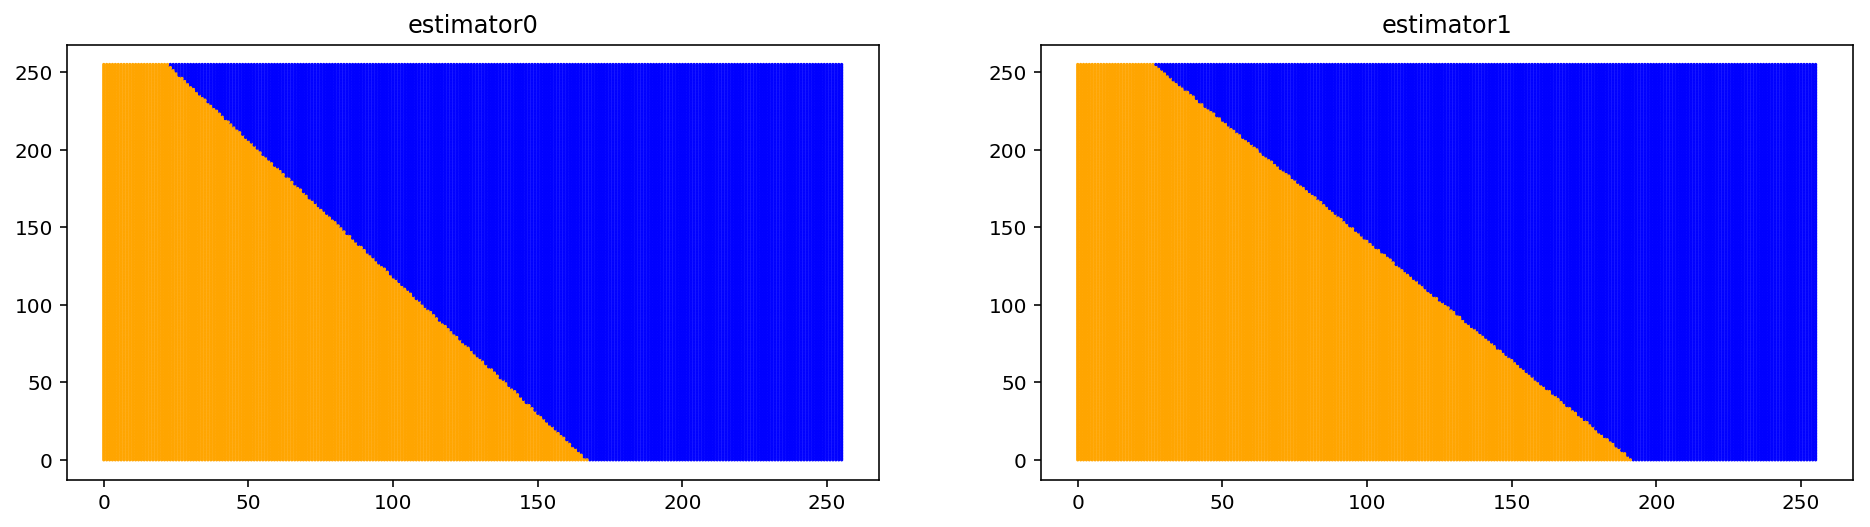

In [6]:
# Drawing many chart 
def DrawManyChart(X,Y,lenth):
    plt.figure(figsize=(16,4))
    for k in range(0,lenth):
        plt.subplot(1,lenth,k+1)
        sct=plt.scatter(X[:,0], X[:,1], c=Y[k],s = 0.4,cmap = cor )
        plt.title( 'estimator' + str(k)) 
    plt.show();

alllabelAB=[];    lenth = len(ABestimator);

for WI in range(0,lenth):
    estimator = ABestimator[WI]
    mylabel = estimator.predict(points)
    alllabelAB.append(mylabel);
DrawManyChart(points,alllabelAB,lenth);

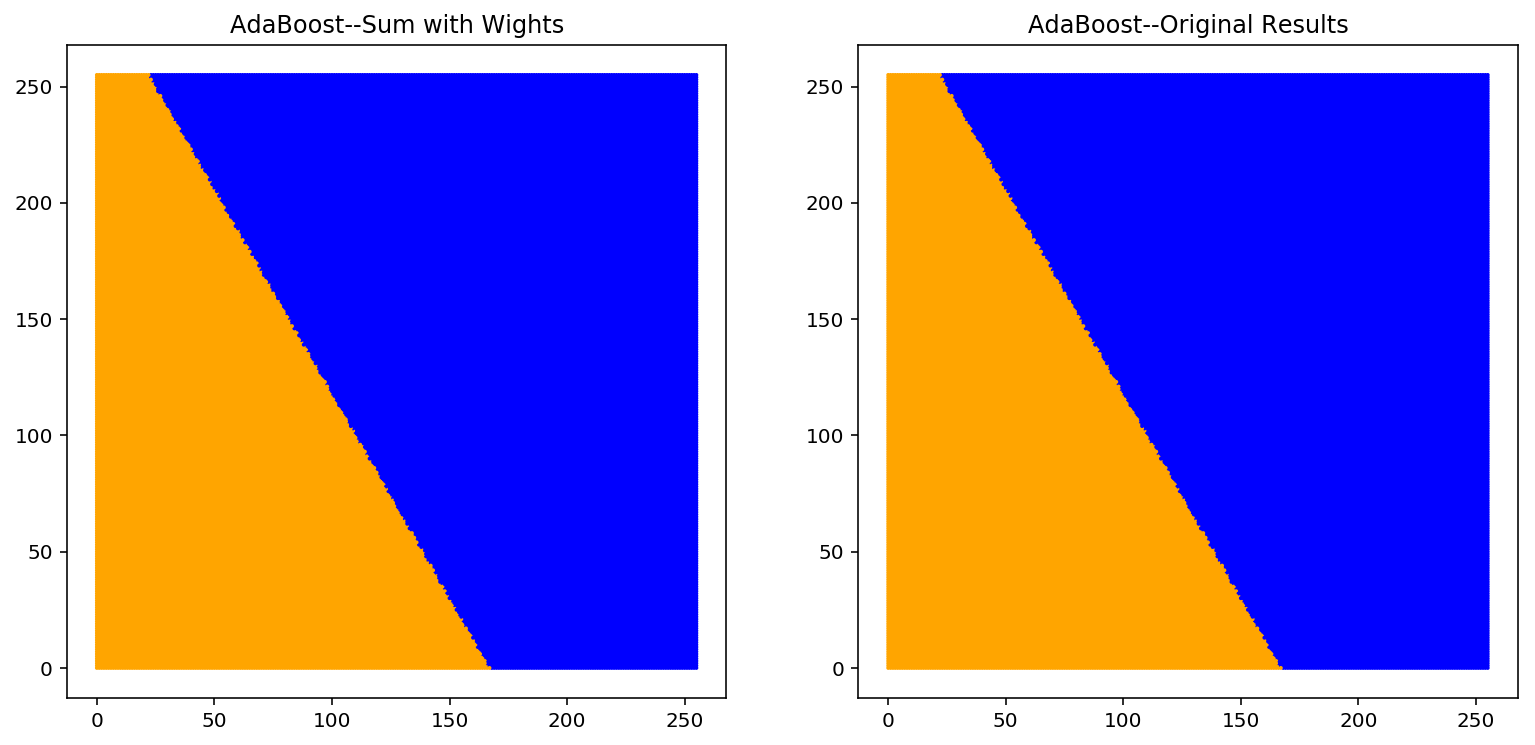

In [7]:
sumlabelAB = alllabelAB[0]*ABweight[0];
for jj in range(1,len(ABestimator)):
    sumlabelAB = sumlabelAB + alllabelAB[jj]*ABweight[jj]; 
finallabelAB = (sumlabelAB>=0)*1 + (sumlabelAB<0)*(-1); 

plt.figure(figsize=(13,6))
plt.subplot(1,2,1);
plt.scatter(points[:,0],points[:,1],c = finallabelAB,s=0.9,cmap=cor)
plt.title('AdaBoost--Sum with Wights');
plt.subplot(1,2,2);
plt.scatter(points[:,0],points[:,1],c = PercepAdaBoostResult,s=0.9,cmap=cor);
plt.title('AdaBoost--Original Results');
plt.show();

### （2）以决策树为弱分类器时AdaBoost的特征选择

In [8]:
# 对于拟合好的分类器模型，获取featureImportance，绘制特征重要性折线图，并打印出重要性最高的前十个特征对应的Index
def SelectFeatureUnderfit(fitModel,titlename):
    featureImport = fitModel.feature_importances_;
    plt.figure(figsize=(12,6), dpi=100);    plt.grid();
    plt.xlabel("Index of features");       afterSorted = sorted( list(featureImport), reverse=True );
    plt.ylabel("feature_importances");   TopValue = afterSorted[0:10];  TopIndex = [ list(featureImport).index(x)+1  for x in TopValue ];    
    plt.scatter(range(1,NumberBands+1), featureImport,s=3,c='r');
    plt.title(titlename,fontsize = 20);    plt.show();
    y_model = fitModel.predict(X_test);
    testscore = accuracy_score(y_test, y_model);    print('测试精度：  ',testscore);
    print('featureImportance的TOP10：',TopValue );   print('featureImportance的TOP10对应的波段：',TopIndex);

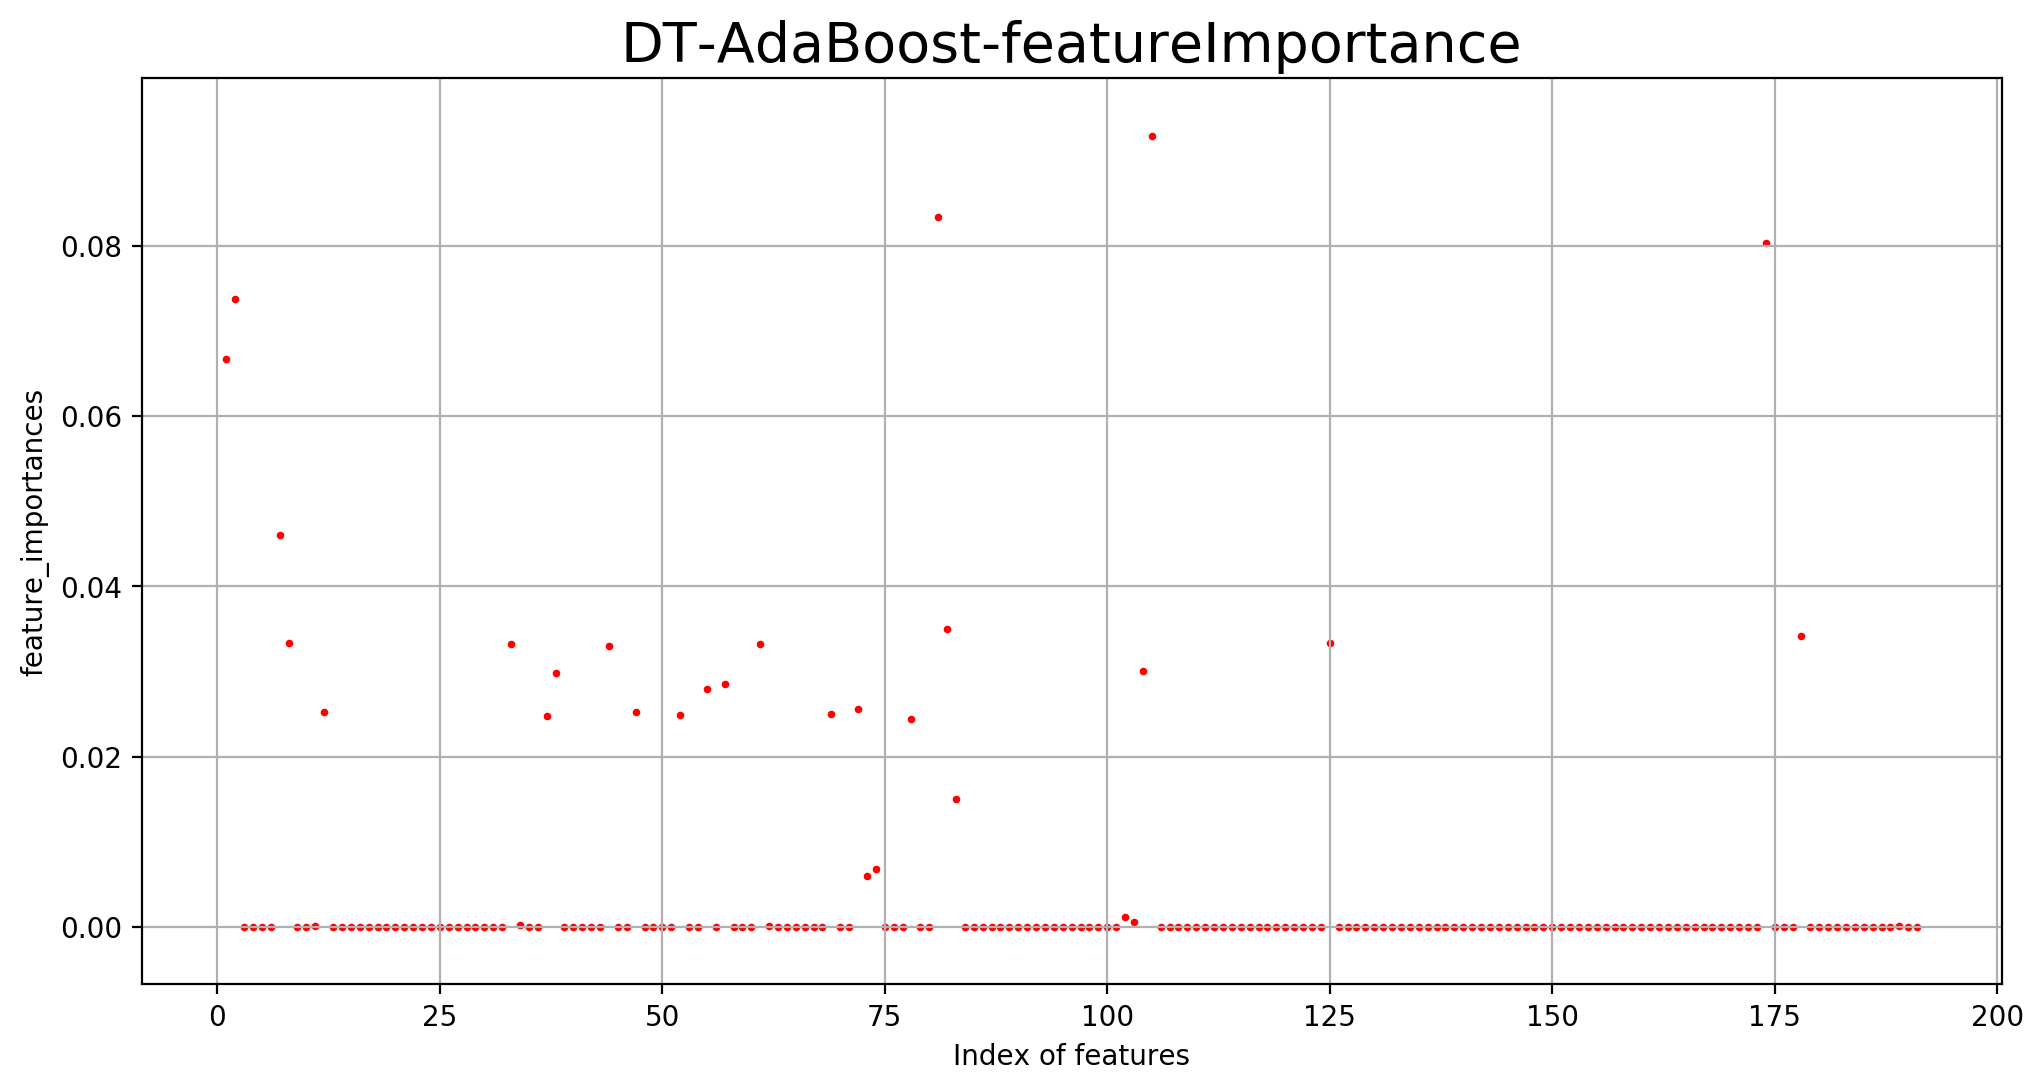

测试精度：   0.994740099009901
featureImportance的TOP10： [0.09287669615484838, 0.08329880091099835, 0.08026405052198525, 0.07377174375876225, 0.06662783521514203, 0.0460085265985886, 0.034962219548381974, 0.03417247410912412, 0.03333324610468231, 0.033330801100775645]
featureImportance的TOP10对应的波段： [105, 81, 174, 2, 1, 7, 82, 178, 8, 125]


In [9]:
AdaBoostClf = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(criterion='gini',max_depth=3), n_estimators = 10);
AdaBoostModel = AdaBoostClf.fit(X_train,y_train);
SelectFeatureUnderfit(AdaBoostModel,'DT-AdaBoost-featureImportance')

### （3）不同弱分类器时AdaBoost的分类精度比较

弱分类器考虑感知机、线性SVM、朴素贝叶斯、SGDclassifer、决策树，基分类器的数量均设置为10.

In [10]:
# 传入基分类器，返回测试精度和分类后的Label
def  EnsembleAdaBoostModel(smallModel):
    AdaBoostClf = AdaBoostClassifier( base_estimator = smallModel, n_estimators = 10, algorithm='SAMME');
    AdaBoostModel = AdaBoostClf.fit(X_train,y_train);
    resultLabel = AdaBoostModel.predict(AllxStandard);
    finaLabel = np.int32(resultLabel.reshape(hang,lie));
    y_model = AdaBoostModel.predict(X_test);
    testscore = accuracy_score(y_test, y_model);
    return finaLabel,testscore;

In [11]:
# 初始化基分类器
PerceptronSmall = Perceptron(penalty = 'l2');
LinearSVM =  svm.LinearSVC(C = 1.0);
NGBsmall = GaussianNB(); 
SGDsmall = SGDClassifier();
DTsmall = DecisionTreeClassifier(criterion='gini',max_depth=3);

finaLabelPER,testscorePER = EnsembleAdaBoostModel(PerceptronSmall);
finaLabelSVM,testscoreSVM = EnsembleAdaBoostModel(LinearSVM);
finaLabelNGB,testscoreNGB = EnsembleAdaBoostModel(NGBsmall);
finaLabelSGD,testscoreSGD = EnsembleAdaBoostModel(SGDsmall);
finaLabelDT,testscoreDT = EnsembleAdaBoostModel(DTsmall);

print('Perceptron-AdaBoost测试精度：  ',testscorePER);
print('SVM-AdaBoost测试精度：  ',testscoreSVM);
print('NGB-AdaBoost测试精度：  ',testscoreNGB);
print('SGD-AdaBoost测试精度：  ',testscoreSGD);
print('DT-AdaBoost测试精度：  ',testscoreDT);

Perceptron-AdaBoost测试精度：   0.9477103960396039
SVM-AdaBoost测试精度：   0.9981435643564357
NGB-AdaBoost测试精度：   0.9848391089108911
SGD-AdaBoost测试精度：   0.8712871287128713
DT-AdaBoost测试精度：   0.994430693069307


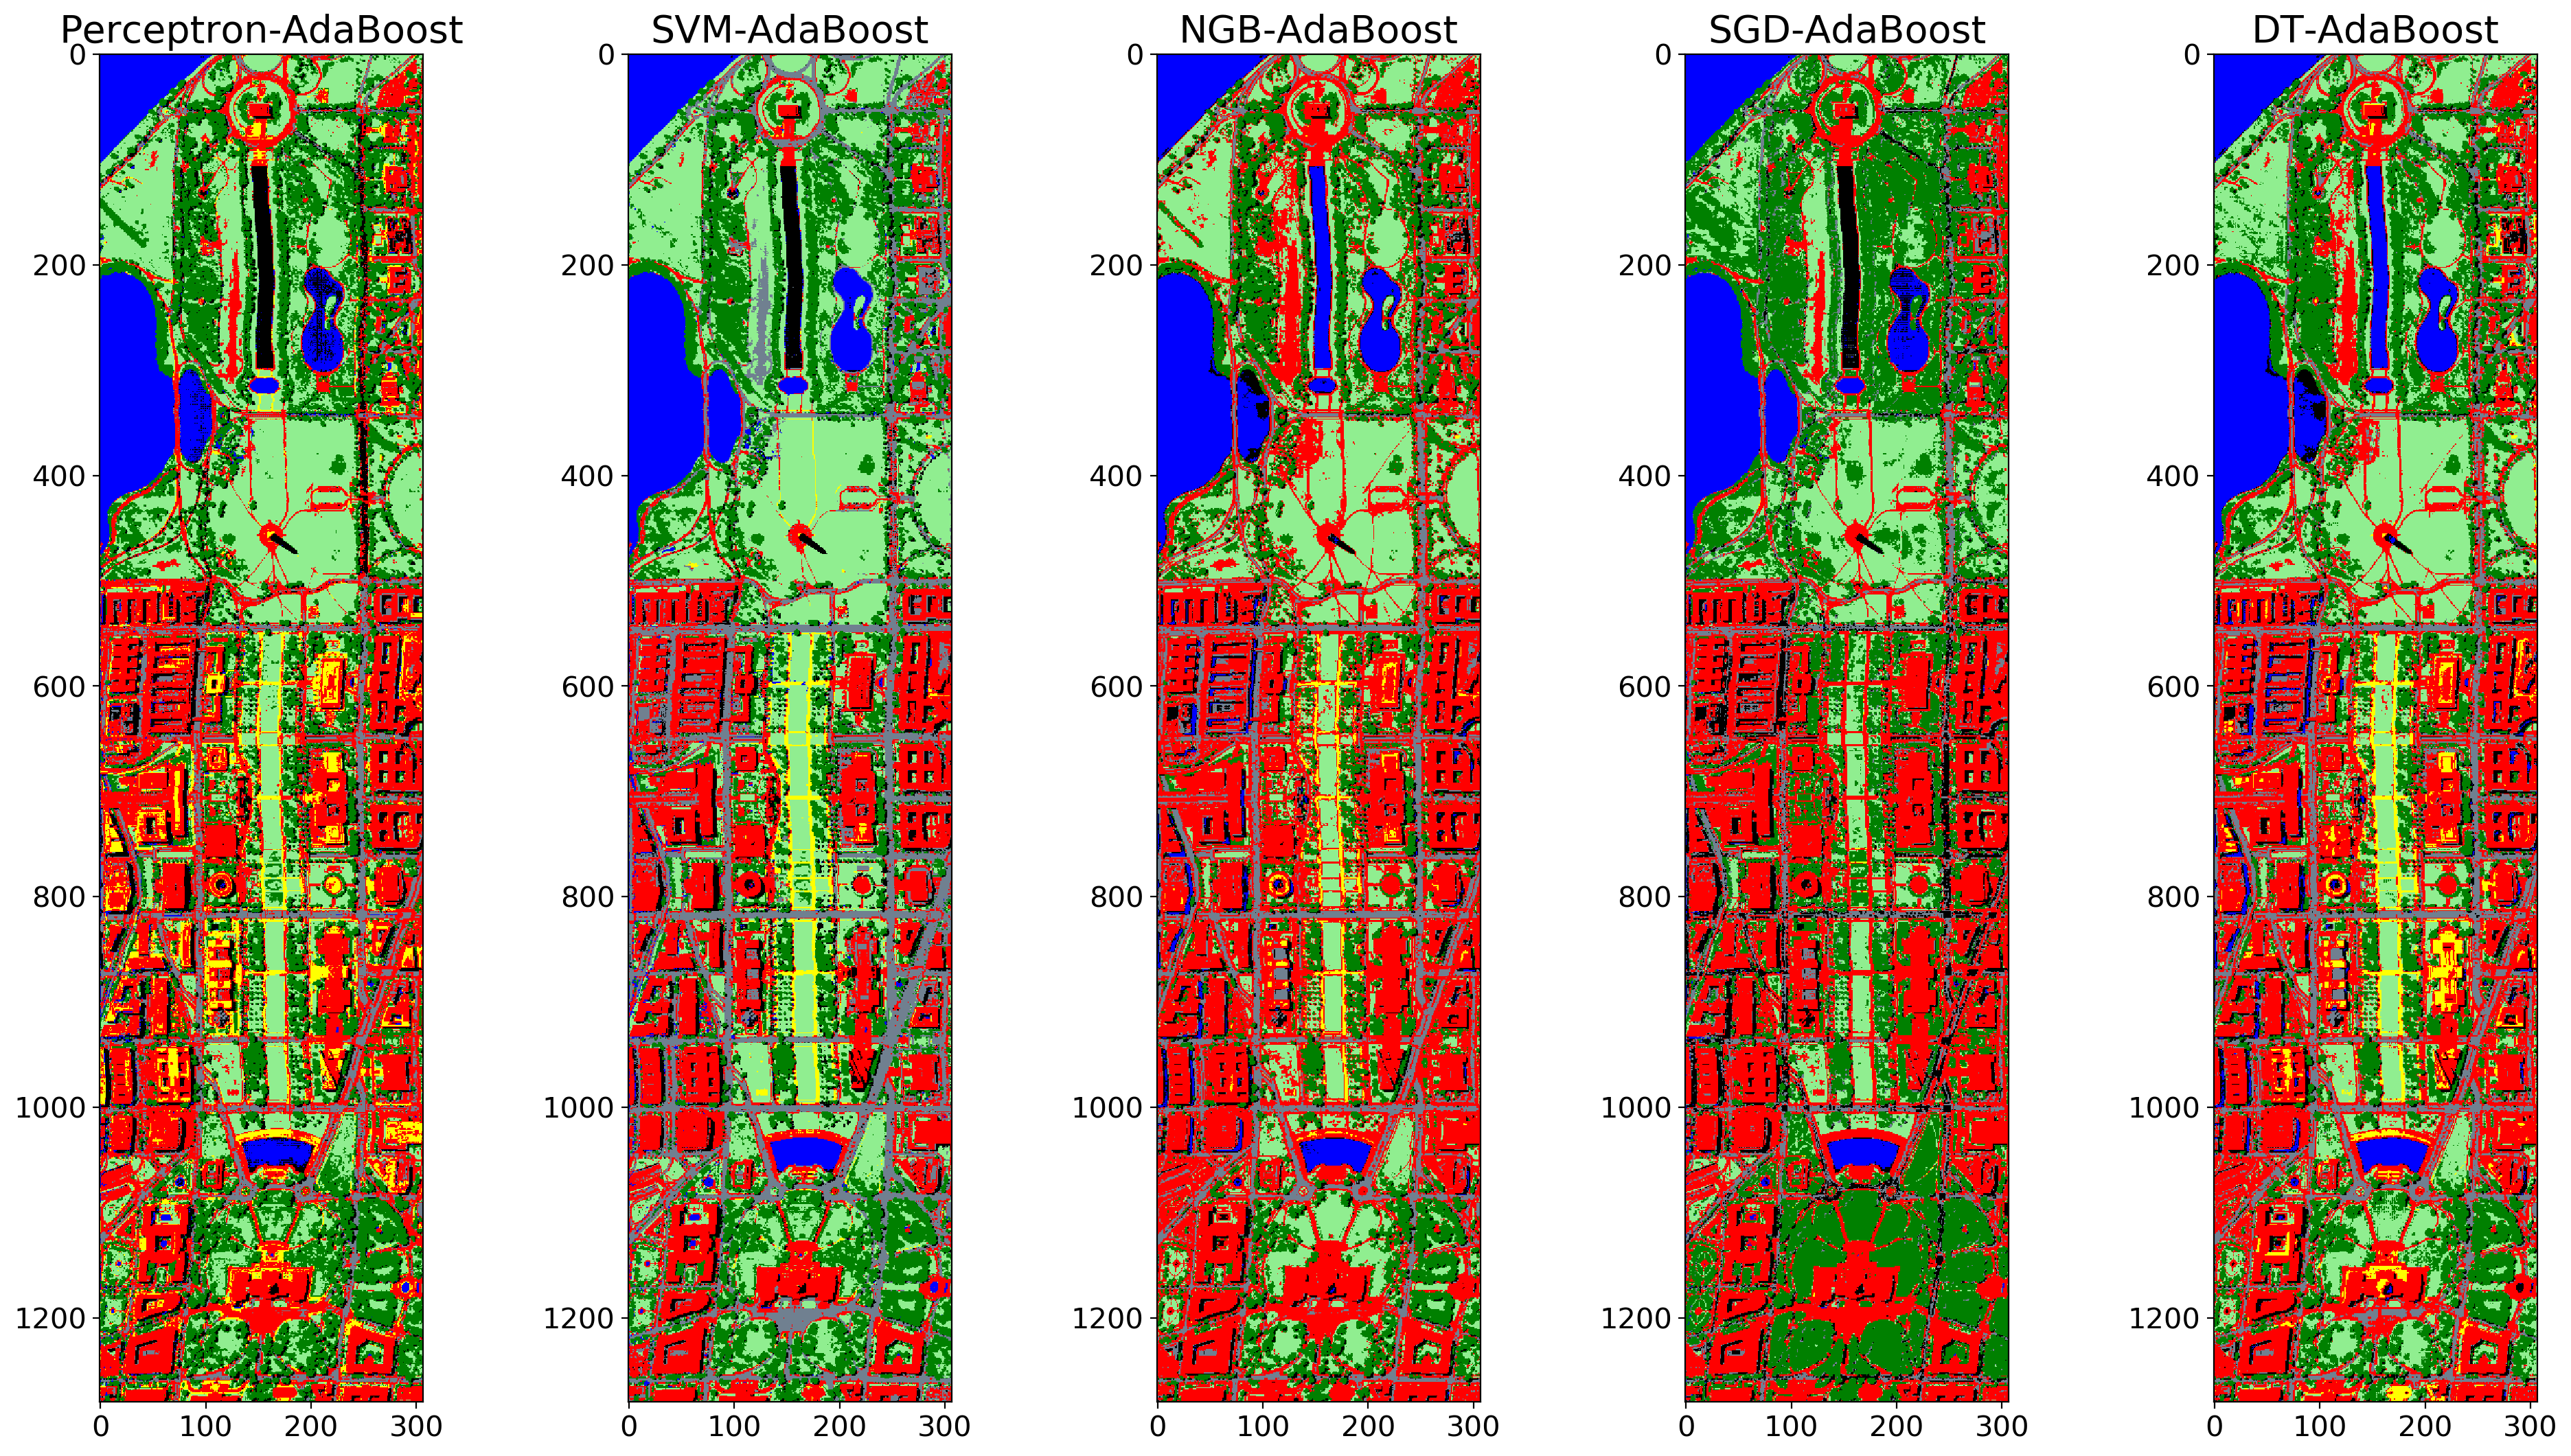

In [12]:
def PlotOne(finalLabel,myplt,index,oneName):
    myplt.subplot(1,5,index);
    TH7color = ['Red','SlateGray','Yellow','LightGreen','Green','BLue','Black' ];
    cor = ListedColormap(TH7color);
    myplt.imshow(finalLabel,cmap=cor); 
    myplt.xticks(fontsize=15);   plt.yticks(fontsize=15);
    myplt.title(oneName,fontsize = 20);

plt.figure(figsize=(24,13), dpi=100);
PlotOne(finaLabelPER,plt,1,'Perceptron-AdaBoost');
PlotOne(finaLabelSVM,plt,2,'SVM-AdaBoost');
PlotOne(finaLabelNGB,plt,3,'NGB-AdaBoost');
PlotOne(finaLabelSGD,plt,4,'SGD-AdaBoost');
PlotOne(finaLabelDT,plt,5,'DT-AdaBoost');
plt.show();

### （4）结点分裂与遥感指数(如NDVI)的关联分析

In [13]:
#将样本分为植被和非植被
def SampleVegetable(YLabel):
    for ii in range(7):
        LI = ii+1;
        itemindex = np.argwhere(YLabel == LI); 
        if ( LI ==4 or LI ==5):
            YLabel[itemindex] = 10;
        else:
            YLabel[itemindex] = 9;
    indexVe = np.argwhere(YLabel == 10);    YLabel[indexVe] = 2; 
    indexNo = np.argwhere(YLabel == 9);    YLabel[indexNo] = 1;
    return YLabel;

In [14]:
def CalculateNDVI(Red,NIR):         #计算NDVI的函数
    NDVI = (NIR - Red)/( 1.0*(NIR + Red) );
    return NDVI;

RedBand = AllxStandard[:,49];    NIRBand = AllxStandard[:,79];   # 取到红波段和近红波段
NDVIband = (CalculateNDVI(RedBand,NIRBand)).reshape(-1,1);  
RedAndNIR = np.hstack((  RedBand.reshape(hang*lie,1) ,NIRBand.reshape(hang*lie,1) )); 

YLabelVeGe = SampleVegetable(YLabelOnedime);    # 原始样本整合为植被和非植被

index=np.where(YLabelVeGe > 0)[0];
Ylabelsample = YLabelVeGe[index];

RedAndNIRdatasamples = RedAndNIR[index,:];
NDVIdatasamples = NDVIband[index,:];

X_trainRN,X_testRN,y_trainRN,y_testRN = train_test_split (RedAndNIRdatasamples,Ylabelsample,
                                                  test_size = 0.4, random_state=2,stratify = Ylabelsample);
X_NDVItrain,X_NDVItest,y_NDVItrain,y_NDVItest = train_test_split (NDVIdatasamples,Ylabelsample,
                                                  test_size = 0.4, random_state=2,stratify = Ylabelsample);

In [15]:
DTCLF = DecisionTreeClassifier( criterion='gini', splitter='best', max_depth = 3,max_features='auto' );
tempModel = DTCLF.fit(X_trainRN,y_trainRN);
featureImport = tempModel.feature_importances_;

DTCLFNDVI = DecisionTreeClassifier( criterion='gini', splitter='best', max_depth = 3,max_features='auto' );
tempModelNDVI = DTCLFNDVI.fit(X_NDVItrain,y_NDVItrain);
featureImportNDVI = tempModelNDVI.feature_importances_;

print('featureImport：',featureImport,'    featureImportNDVI：',featureImportNDVI )

featureImport： [0.28009304 0.71990696]     featureImportNDVI： [1.]


In [16]:
y_modelRN = tempModel.predict(X_testRN);
testscore = accuracy_score(y_testRN, y_modelRN);

y_modelNDVI = tempModelNDVI.predict(X_NDVItest);
testscoreNDVI = accuracy_score(y_NDVItest, y_modelNDVI);
# 测试精度输出，并比较
print('testscore：',testscore,'    testscoreNDVI：',testscoreNDVI )

testscore： 0.9916460396039604     testscoreNDVI： 0.838490099009901


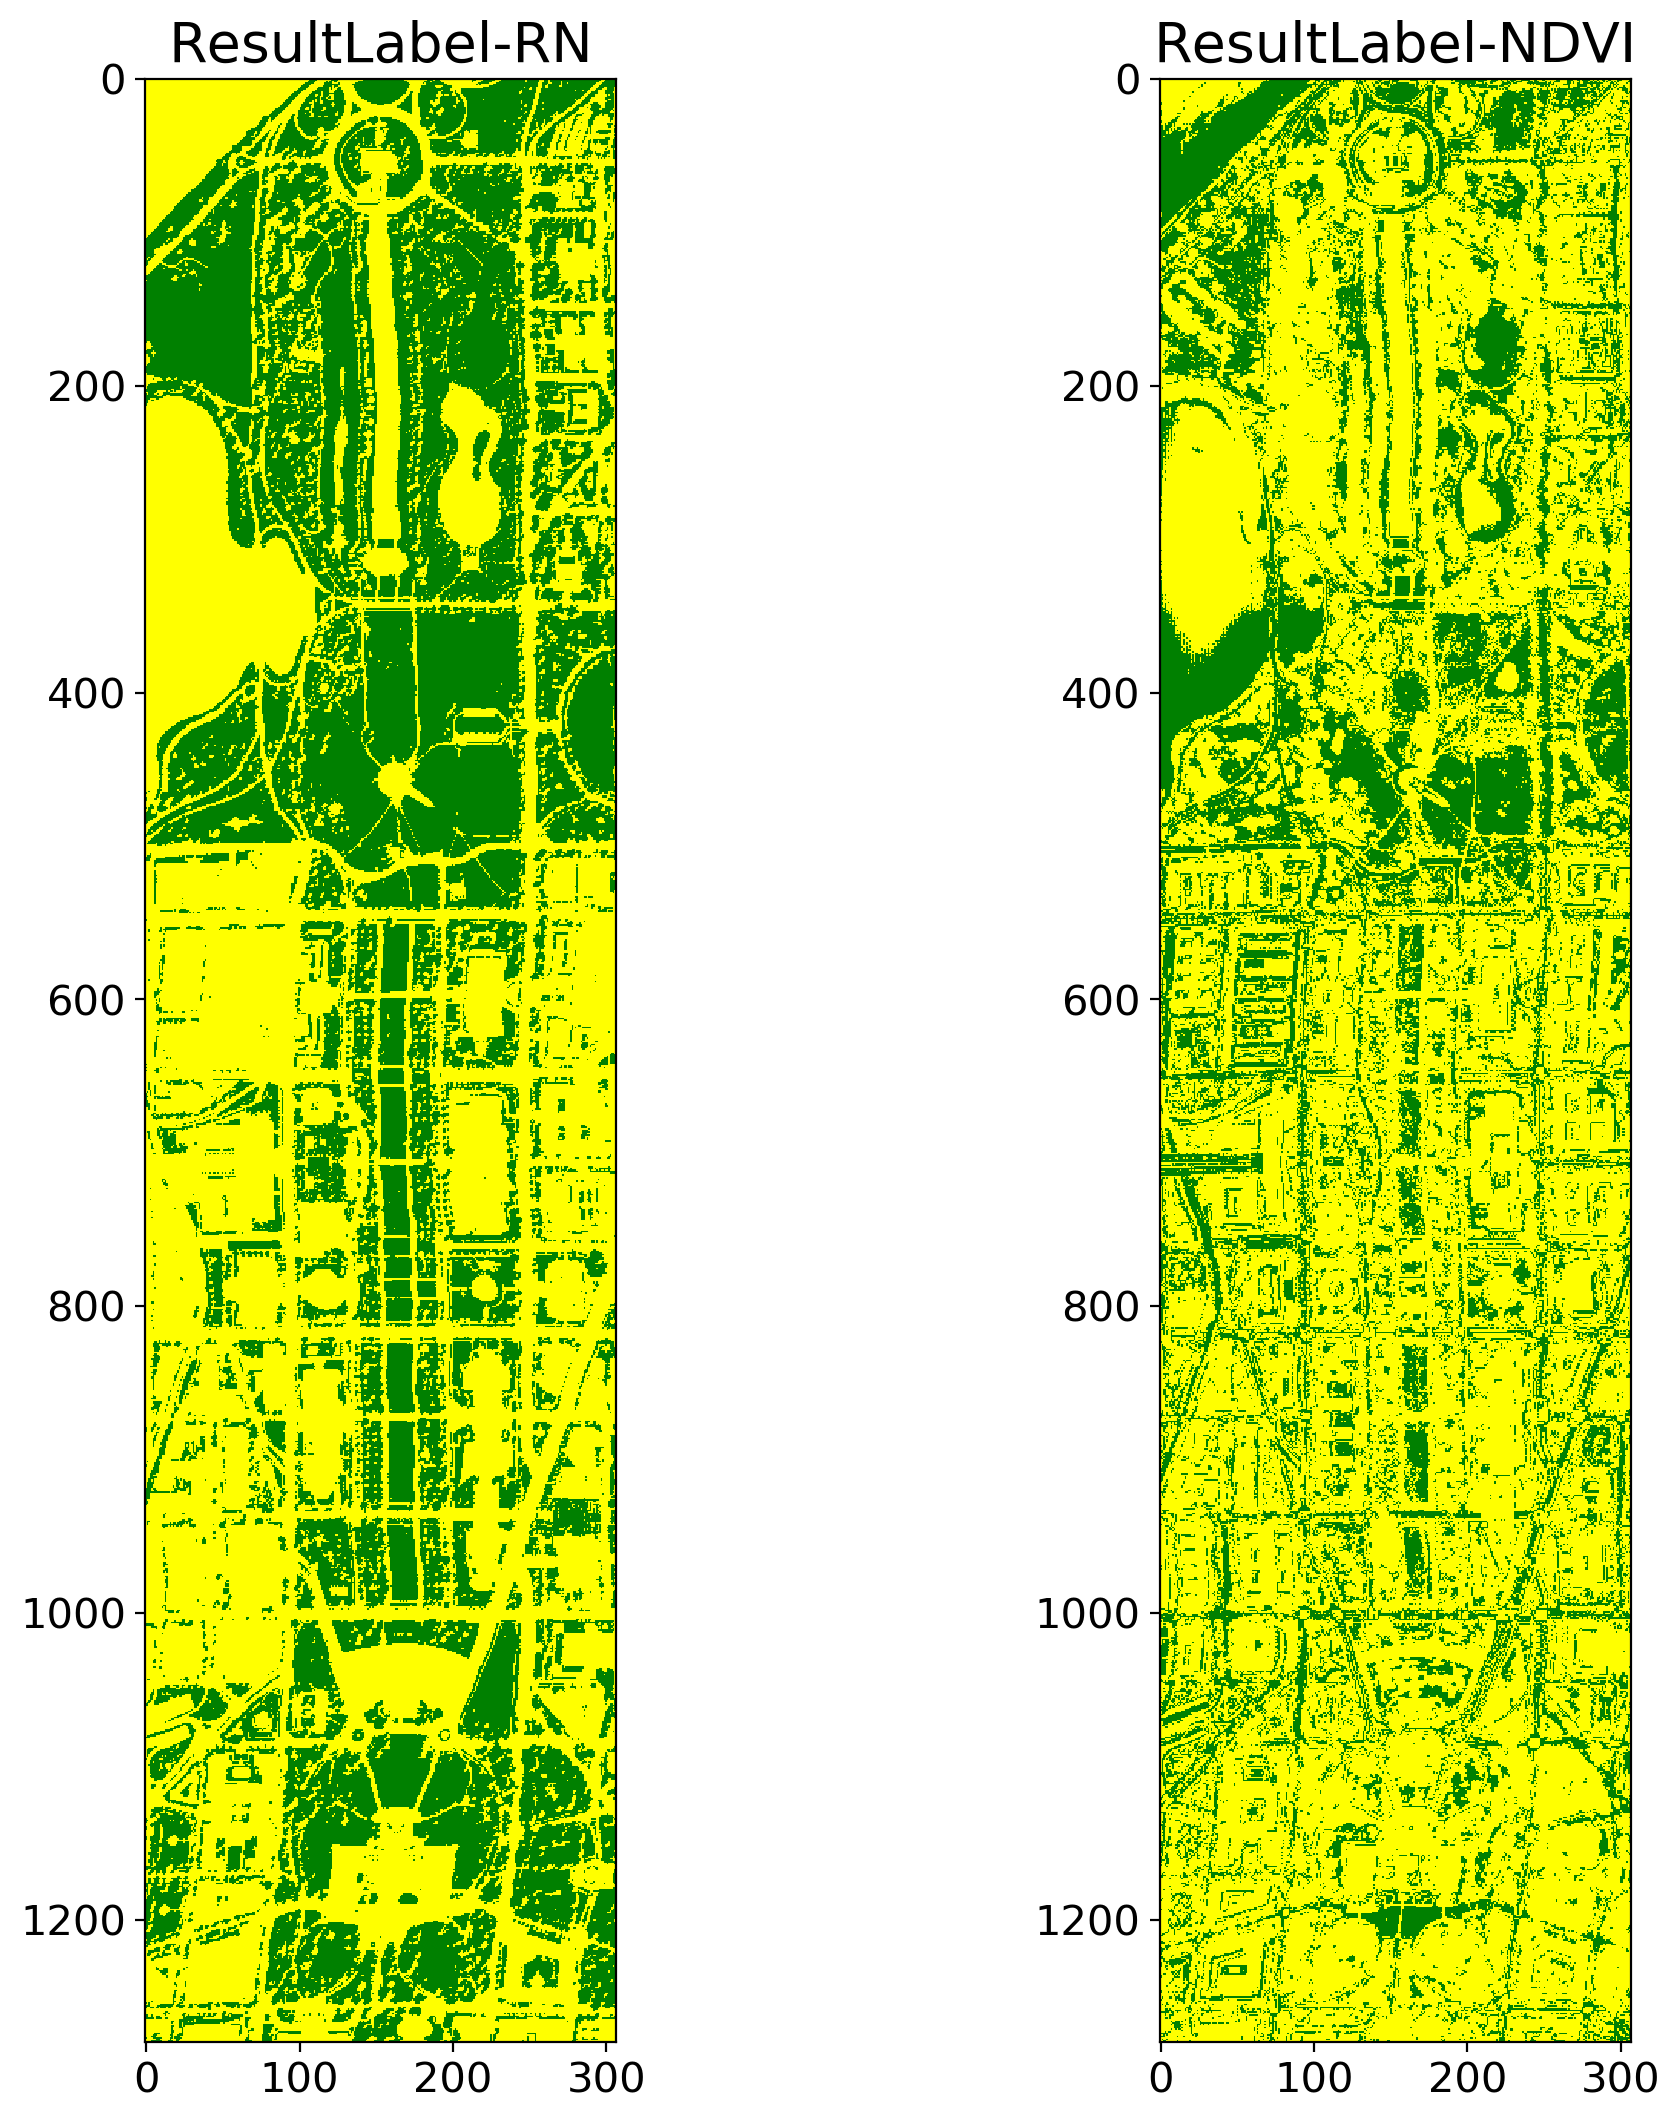

In [17]:
ResultLabelRN = tempModel.predict( RedAndNIR ); 

plt.figure(figsize=(12,13), dpi=100);
TH7color = ['Yellow','Green'];
cor = ListedColormap(TH7color);
finaLabelRN = np.int32(ResultLabelRN.reshape(hang,lie));
plt.subplot(1,2,1);
plt.imshow(finaLabelRN,cmap=cor); 
plt.xticks(fontsize=15);   plt.yticks(fontsize=15);
plt.title('ResultLabel-RN',fontsize = 20);

ResultLabelNDVI = tempModelNDVI.predict( NDVIband ); 
finaLabelNDVI = np.int32(ResultLabelNDVI.reshape(hang,lie));
plt.subplot(1,2,2);
plt.imshow(finaLabelNDVI,cmap=cor); 
plt.xticks(fontsize=15);   plt.yticks(fontsize=15);
plt.title('ResultLabel-NDVI',fontsize = 20);

从分类精度和效果上看，将红光和近红外作为两个特征、将计算出的NDVI作为单特征，分别作为决策树的输入，前者的精度显著高于后者，分类效果也明显更好。进一步分析原因，绘制出两种情况下的决策树结构，如下图所示。NDVI值可转化为在以红波段和近红波段的二维特征空间中的直线斜率，两种情况都实现对二维特征空间的剖分，划分趋势基本一致，双波段的比单波段NDVI的剖分更好。可以想象，当输入特征较多时，即是实现在高维特征空间的剖分。

![](Picture/NDVITREE.JPG)

### （5）不同节点纯度下决策树特征选择的差异

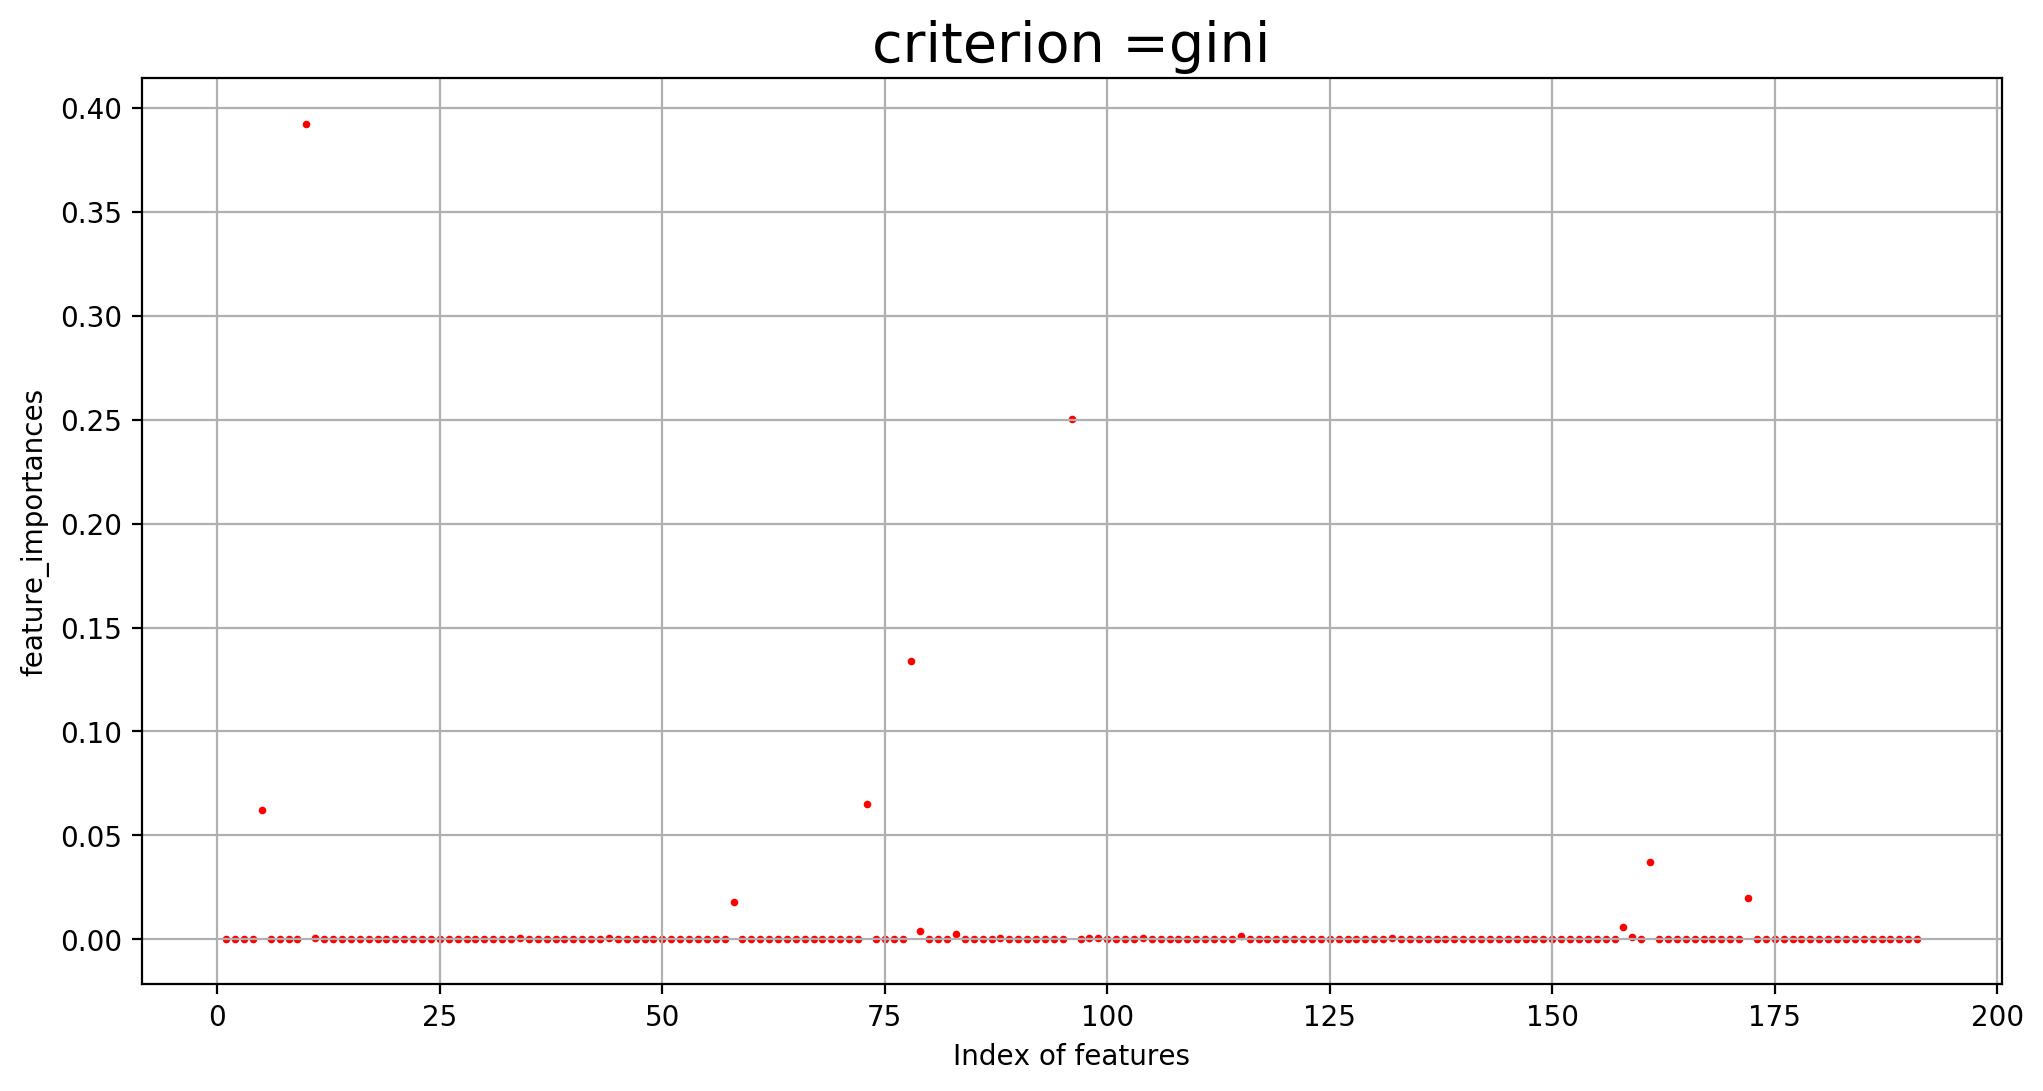

测试精度：   0.9925742574257426
featureImportance的TOP10： [0.3925510096781679, 0.25037821835398644, 0.13378029539243835, 0.065102901745176, 0.06244947740670906, 0.037159227774806486, 0.01991624987277024, 0.017851375149456776, 0.0058055011126382575, 0.004107069027518291]
featureImportance的TOP10对应的波段： [10, 96, 78, 73, 5, 161, 172, 58, 158, 79]


In [18]:
# criterion（节点分裂方式）为 “gini”(基尼指数)或者“entropy”（信息增益）情况下的特征选择
giniDTCLF = DecisionTreeClassifier( criterion = 'gini', splitter='best', max_depth = 10,max_features='auto' );
giniModel = giniDTCLF.fit(X_train,y_train);

SelectFeatureUnderfit(giniModel,'criterion =gini');

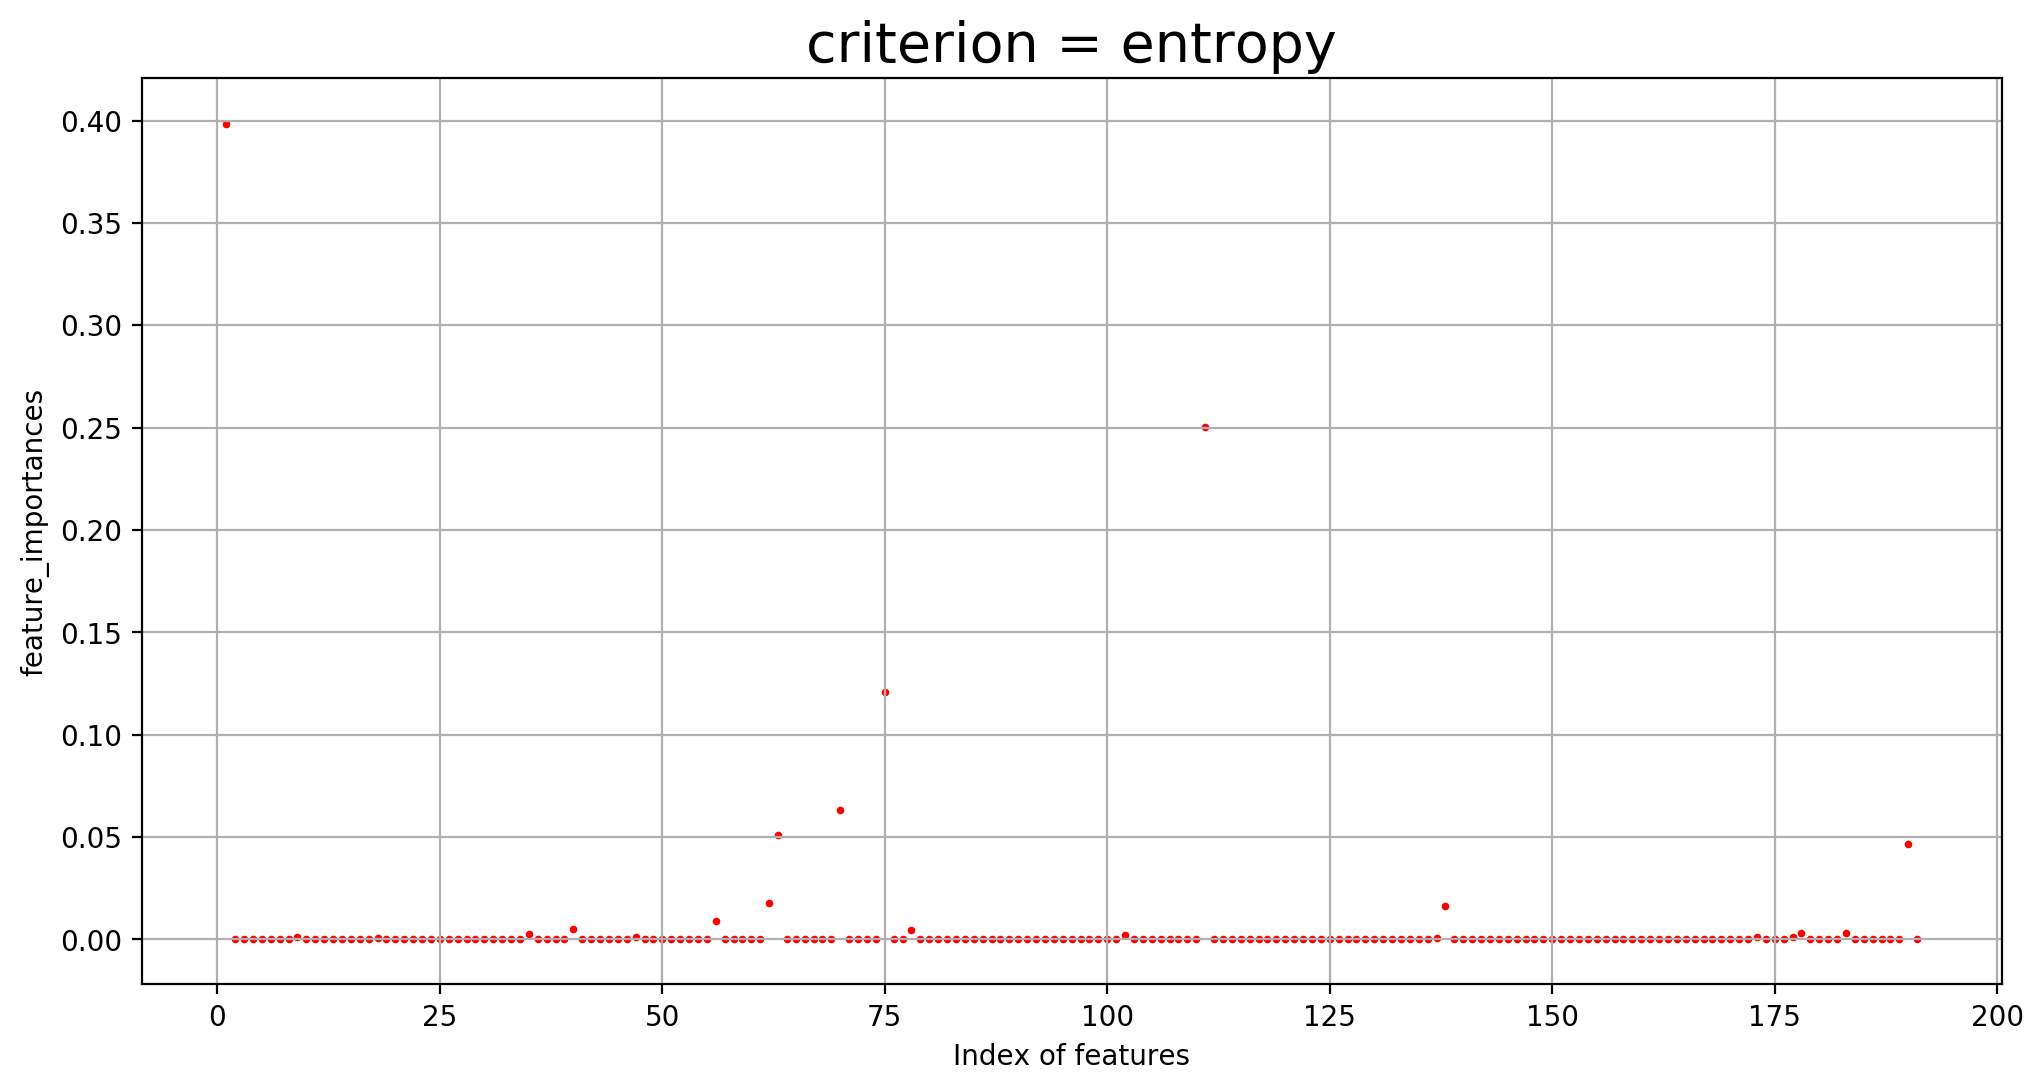

测试精度：   0.9922648514851485
featureImportance的TOP10： [0.39855058289651857, 0.25010076470548265, 0.12093037182489126, 0.0630267753066363, 0.050935661043367525, 0.046789333709724386, 0.01758068349913379, 0.0162329763539965, 0.009180067209474034, 0.005063377787096002]
featureImportance的TOP10对应的波段： [1, 111, 75, 70, 63, 190, 62, 138, 56, 40]


In [19]:
entropyDTCLF = DecisionTreeClassifier( criterion = 'entropy', splitter='best', max_depth = 10,max_features='auto' );
entropyModel = entropyDTCLF.fit(X_train,y_train);

SelectFeatureUnderfit(entropyModel,'criterion = entropy');

### （6）RF中树的数量对分类器性能的影响

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier();
# 网格搜索随机森林最优参数组合
param_grid = {'n_estimators': np.arange(5,30,3), 
 'max_depth':np.arange(1,20,3), 'criterion':['gini','entropy']}
grid = GridSearchCV(model, param_grid, cv=5);
grid.fit(X_train,y_train);
print('最优超参数组合：         ',grid.best_params_);   print('Train_best_score:    ',grid.best_score_);
bestmodel = grid.best_estimator_;

最优超参数组合：          {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 11}
Train_best_score:     0.9964926758819889


testscore:      0.9941212871287128


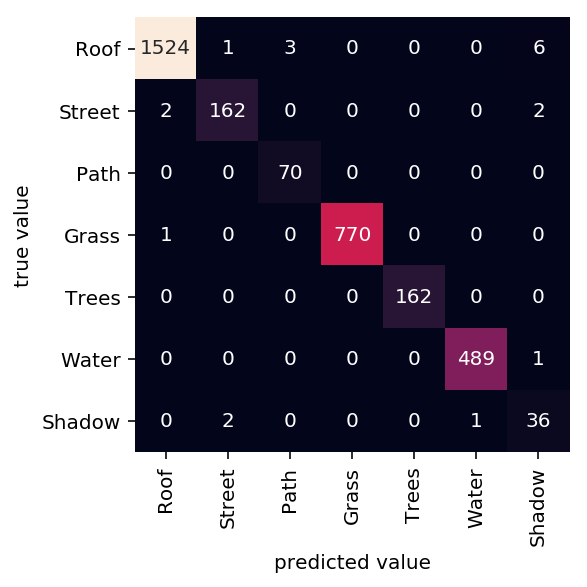

In [21]:
# 最优超参数下的测试精度和混淆矩阵
from sklearn.metrics import accuracy_score
y_model = bestmodel.predict(X_test);
testscore = accuracy_score(y_test, y_model);     print('testscore:     ',testscore);
ResultLabel = bestmodel.predict( AllxStandard ); 

import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_model);              stringName = ['Roof','Street','Path','Grass','Trees','Water','Shadow'];
sns.heatmap(mat, square=True, annot=True,fmt='d', cbar=False, xticklabels = stringName, yticklabels = stringName );
plt.xlabel('predicted value');           plt.ylabel('true value');

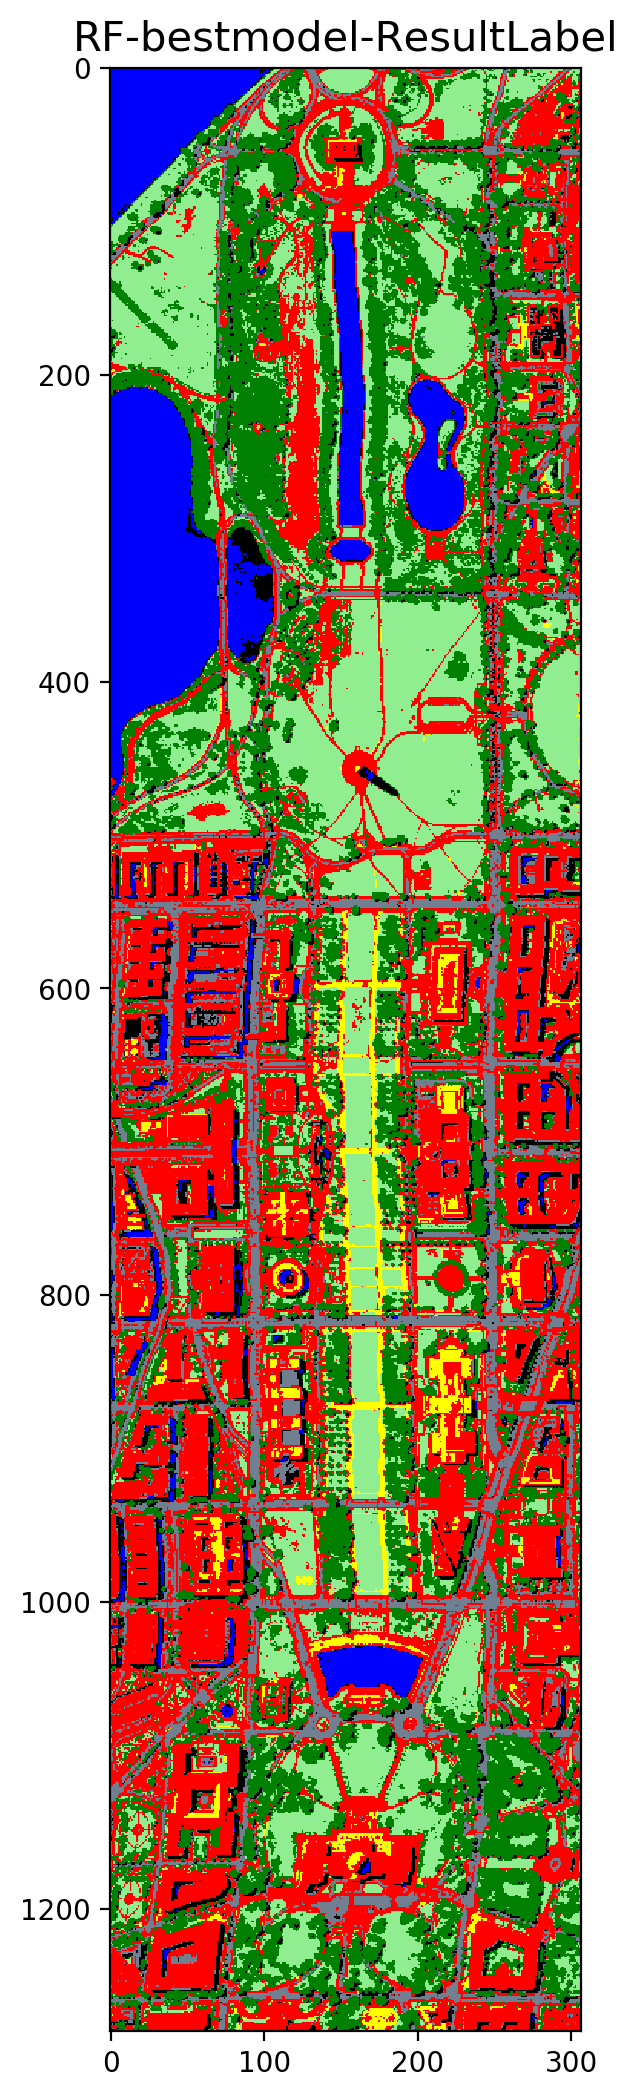

In [22]:
# 最优超参数下的分类结果
plt.figure(figsize=(6,13), dpi=100);
TH7color = ['Red','SlateGray','Yellow','LightGreen','Green','BLue','Black' ];
cor = ListedColormap(TH7color);
finaLabel=np.int32(ResultLabel.reshape(hang,lie));
plt.imshow(finaLabel,cmap=cor); 
plt.xticks(fontsize=10);   plt.yticks(fontsize=10);
plt.title('RF-bestmodel-ResultLabel',fontsize = 15);

In [23]:
# 改变一个参数，如树的棵树、树的最大深度，计算对应的测试精度
def changeOneParamDrawScore(oneParam,NTree,MDepth):
    if oneParam == 'numberTree':
        clfRF = RandomForestClassifier(n_estimators = NTree, criterion = 'gini',max_depth = 3);
    if oneParam == 'maxdepth':
        clfRF = RandomForestClassifier(n_estimators = 28, criterion = 'gini',max_depth = MDepth);
    tempModel = clfRF.fit(X_train, y_train);
    y_model = tempModel.predict(X_test);
    testscore = accuracy_score(y_test, y_model); 
    return  testscore;  

# 绘制测试精度变化折线
def PlotTestScore(Xrange,Yrange,Xlabe):
    plt.figure(figsize=(12,6), dpi=100);
    plt.xlabel(Xlabe);  plt.grid();
    plt.ylabel("Test score")
    plt.plot(Xrange, Yrange) 
    plt.yticks(fontsize=10); 
    if np.max(Xrange)>50:
        plt.ylim(0.85,1.0);
        plt.xticks(np.arange(1,60,2),fontsize=10);
    else:
        plt.xticks(Xrange,fontsize=10);
    plt.show();

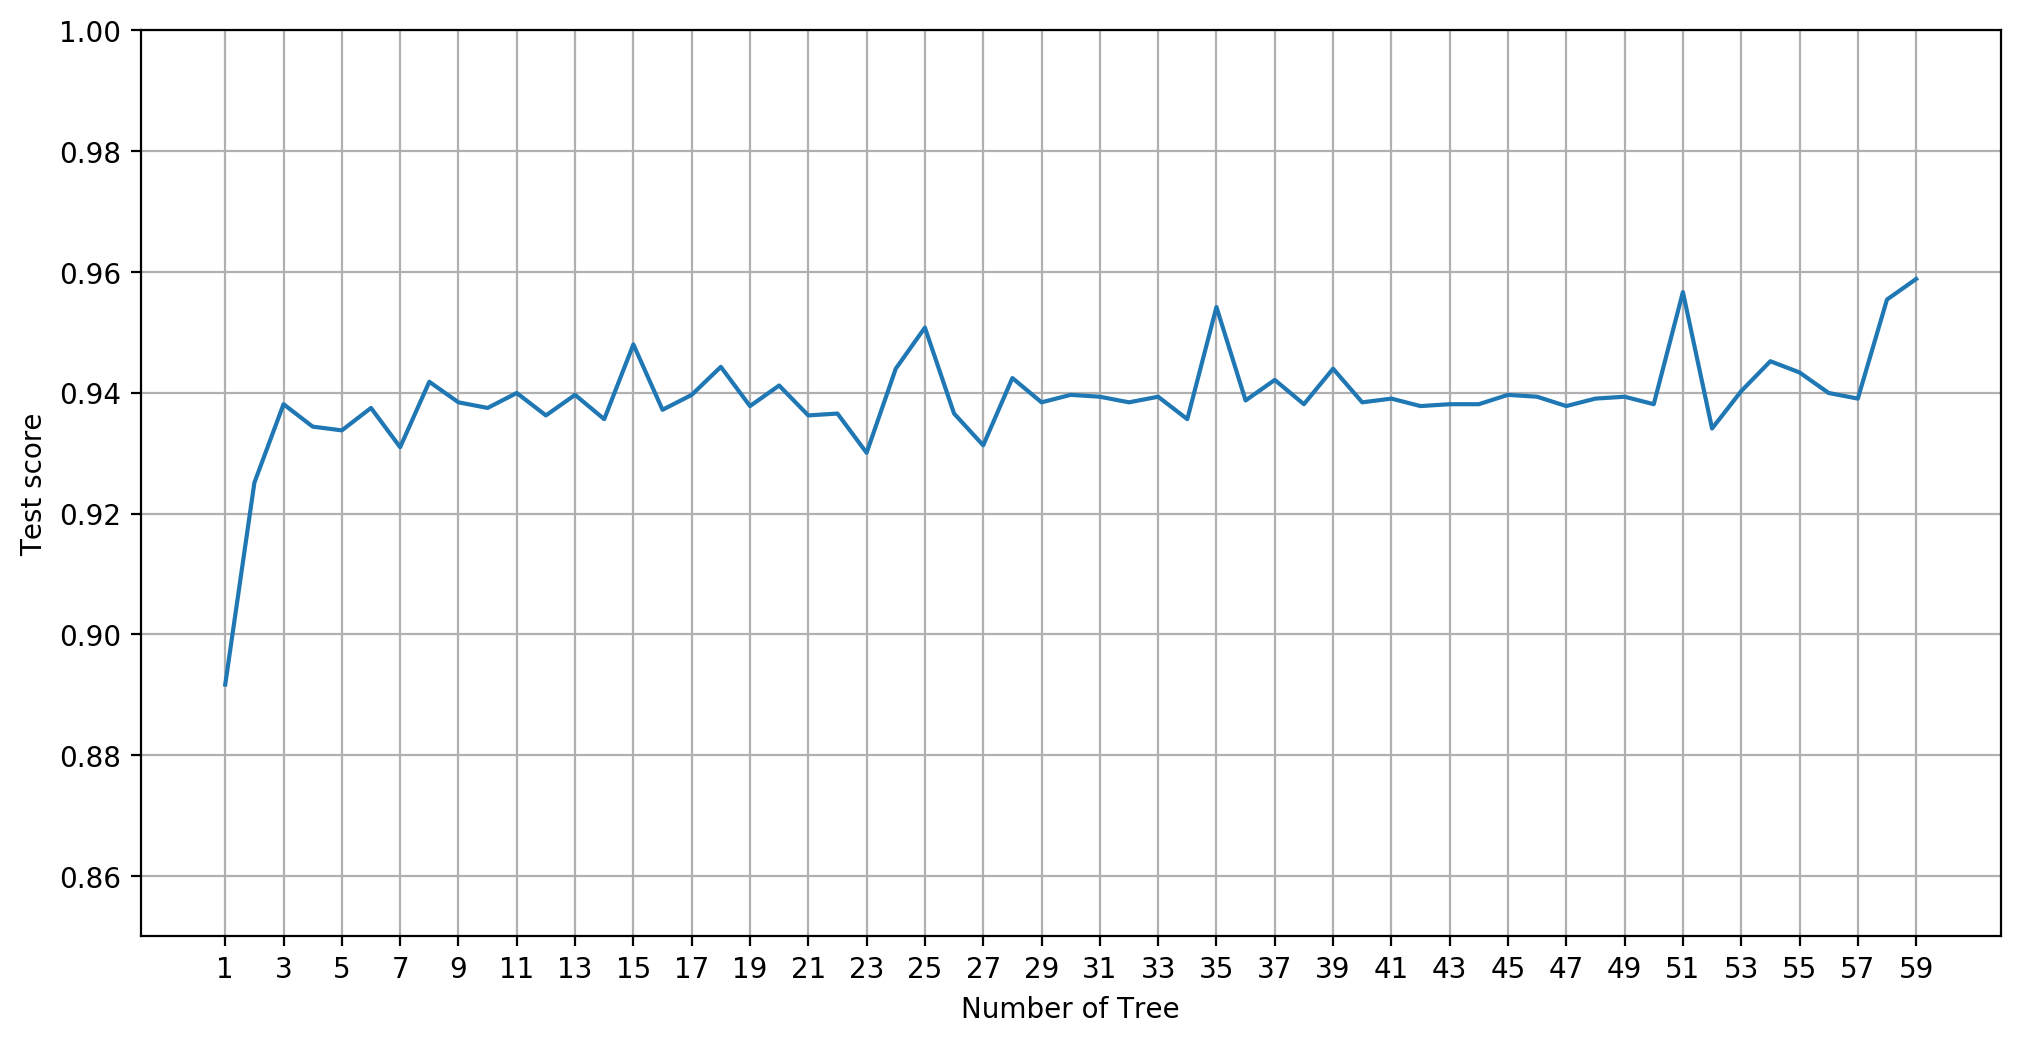

In [24]:
NumberTree = np.arange(1,60,1);       Maxdepth = np.arange(1,20,1);
allTestScore =[];
for ii in NumberTree:
    TempTestScore = changeOneParamDrawScore('numberTree',ii,0);
    allTestScore.append(TempTestScore);   
PlotTestScore(NumberTree,allTestScore,'Number of Tree');   

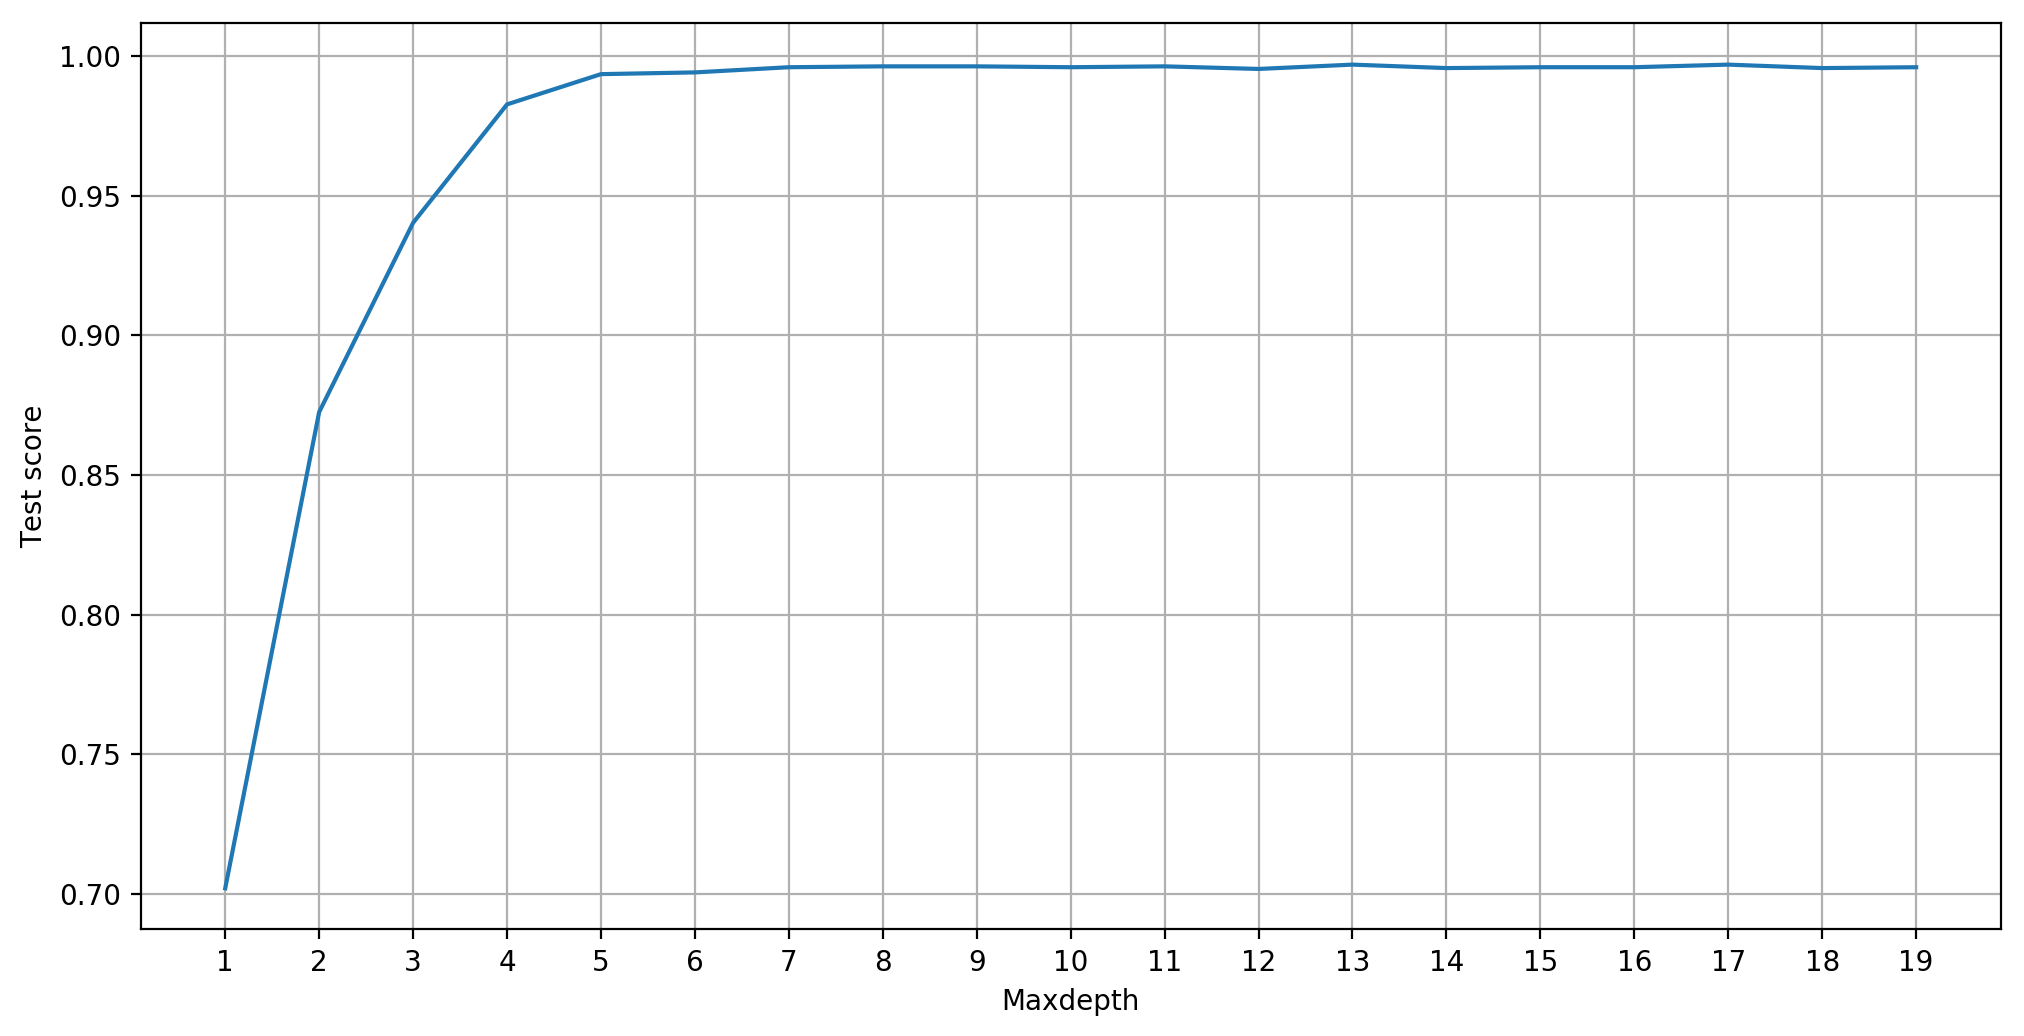

In [25]:
allMaxdepthScore =[];
for jj in np.arange(1,20,1):
    TempMDScore = changeOneParamDrawScore('maxdepth',0,jj);
    allMaxdepthScore.append(TempMDScore);
PlotTestScore(Maxdepth,allMaxdepthScore,'Maxdepth');

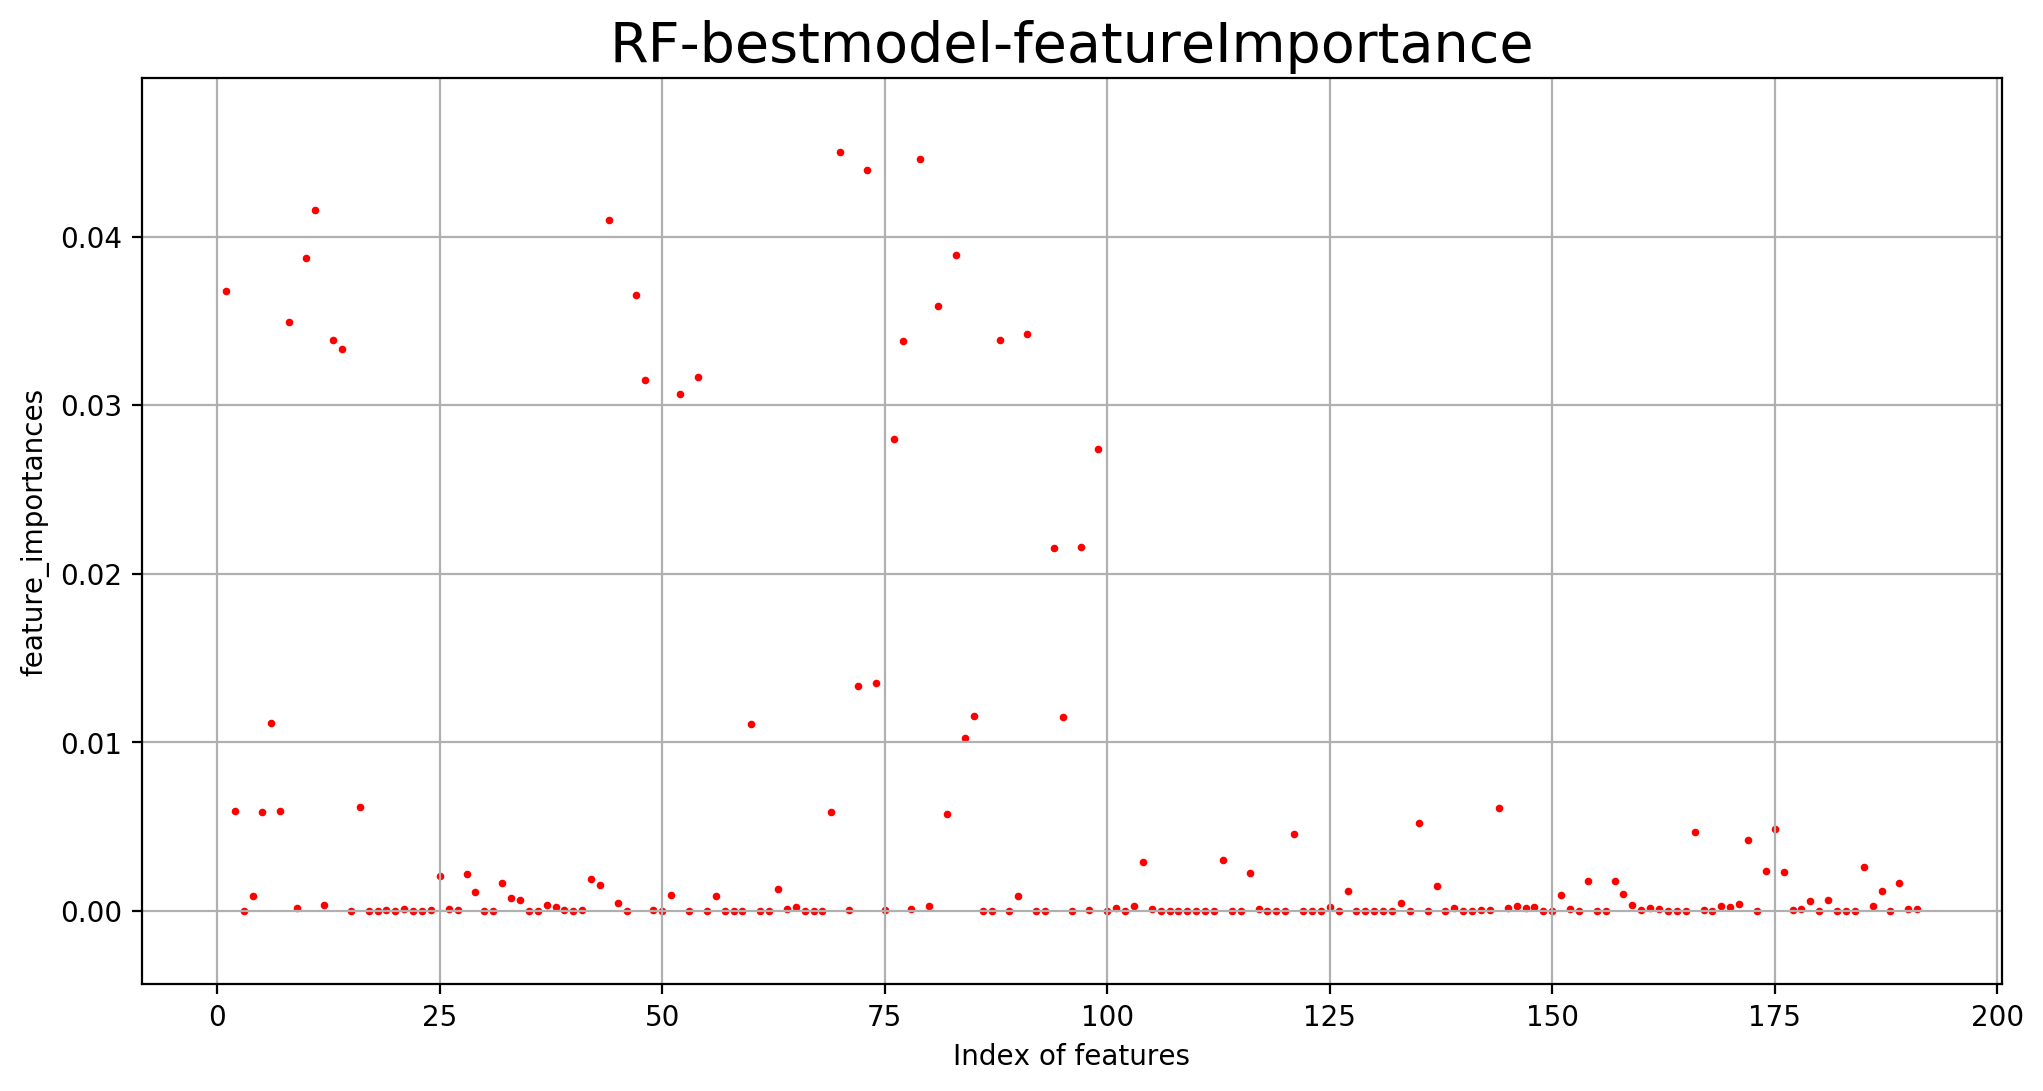

测试精度：   0.9941212871287128
featureImportance的TOP10： [0.045028594003287986, 0.04460925191328038, 0.04398093577261078, 0.041589928854563654, 0.04096043834666191, 0.038913859967946225, 0.03872827531725886, 0.03677779388540944, 0.036530271751409334, 0.03586707988690878]
featureImportance的TOP10对应的波段： [70, 79, 73, 11, 44, 83, 10, 1, 47, 81]


In [26]:
SelectFeatureUnderfit(bestmodel,'RF-bestmodel-featureImportance');